I'll be using this notebook as a platform to flex  my newly acquired network analysis muscles. I'll be putting this project together over the next month or so as I learn to use the networkx library in Python.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import re

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

This is a monster of a file and it makes my life easier to test out my function-writing skills on smaller pieces of it. I'll use a tiny chunksize to give me something to play with. Once I know exactly how I'm going to get the job done I'll (try to) scale back up to the full dataset.

In [2]:
pd.options.mode.chained_assignment = None

chunk = pd.read_csv('../input/emails.csv', chunksize=500)
data = next(chunk)

data.info()
print(data.message[2])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
file       500 non-null object
message    500 non-null object
dtypes: object(2)
memory usage: 7.9+ KB
Message-ID: <24216240.1075855687451.JavaMail.evans@thyme>
Date: Wed, 18 Oct 2000 03:00:00 -0700 (PDT)
From: phillip.allen@enron.com
To: leah.arsdall@enron.com
Subject: Re: test
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Leah Van Arsdall
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Dec2000\Notes Folders\'sent mail
X-Origin: Allen-P
X-FileName: pallen.nsf

test successful.  way to go!!!


Looks like all these messages share the same structure, which is quite convenient. It means I can split the text by newline ('\n\') and then simply slice the resulting list to access specific elements of each email. Then I can assign them to new dataframe columns and clean them up for further exploration. 

Let's write some functions (thank you DataCamp and Hugo Bowne-Anderson)!

In [3]:
def get_text(Series, row_num_slicer):
    """returns a Series with text sliced from a list split from each message. Row_num_slicer
    tells function where to slice split text to find only the body of the message."""
    result = pd.Series(index=Series.index)
    for row, message in enumerate(Series):
        message_words = message.split('\n')
        del message_words[:row_num_slicer]
        result.iloc[row] = message_words
    return result

def get_row(Series, row_num):
    """returns a single row split out from each message. Row_num is the index of the specific
    row that you want the function to return."""
    result = pd.Series(index=Series.index)
    for row, message in enumerate(Series):
        message_words = message.split('\n')
        message_words = message_words[row_num]
        result.iloc[row] = message_words
    return result

def get_address(df, Series, num_cols=1):
    """returns a specified email address from each row in a Series"""
    address = re.compile('[\w\.-]+@[\w\.-]+\.\w+')
    addresses = []
    result1 = pd.Series(index=df.index)
    result2 = pd.Series(index=df.index)
    result3 = pd.Series(index=df.index)
    for i in range(len(df)):
        for message in Series:
            correspondents = re.findall(address, message)
            addresses.append(correspondents)
            result1[i] = addresses[i][0]
        if num_cols >= 2:
            if len(addresses[i]) >= 3:
                result2[i] = addresses[i][1]
                if num_cols == 3:
                    if len(addresses[i]) >= 4:
                        result3[i] = addresses[i][2]
    return result1, result2, result3

def standard_format(df, Series, string, slicer):
    """Drops rows containing messages without some specified value in the expected locations. 
    Returns original dataframe without these values. Don't forget to reindex after doing this!!!"""
    rows = []
    for row, message in enumerate(Series):
        message_words = message.split('\n')
        if string not in message_words[slicer]:
            rows.append(row)
    df = df.drop(df.index[rows])
    return df

My standard_format() function is meant to get rid of messages that are missing crucial information that I need to do my analysis. For instance several messages have no To: line, which means I have no one to connect these messages to in my network. I need to get rid of these or they will screw up my get_row() function when I try to pull out the To: line information.

In [4]:
x = len(data.index)
headers = ['Message-ID: ', 'Date: ', 'From: ', 'To: ', 'Subject: ']
for i, v in enumerate(headers):
    data = standard_format(data, data.message, v, i)
data = data.reset_index()
print("Got rid of {} useless emails! That's {}% of the total number of messages in this dataset.".format(x - len(data.index), np.round(((x - len(data.index)) / x) * 100, decimals=2)))

Got rid of 11 useless emails! That's 2.2% of the total number of messages in this dataset.


Got rid of 11 offenders. Not bad! Now to pull out the rest of the data I want to examine. Playing around with my chunksize it looks like when I scale this up I'll lose nearly a quarter of my emails, mostly because they don't have an addressee.

In [5]:
data['text'] = get_text(data.message, 15)
data['date'] = get_row(data.message, 1)
data['senders'] = get_row(data.message, 2)
data['recipients'] = get_row(data.message, 3)
data['subject'] = get_row(data.message, 4)

data.date = data.date.str.replace('Date: ', '')
data.date = pd.to_datetime(data.date)

data.subject = data.subject.str.replace('Subject: ', '')

data['recipient1'], data['recipient2'], data['recipient3'] = get_address(data, data.recipients, num_cols=3)
data['sender'], x, y = get_address(data, data.senders)

del data['recipients']
del data['senders']
del data['file']
del data['message']

data = data[['date', 'sender', 'recipient1', 'recipient2', 'recipient3', 'subject', 'text']]

print(data.head())

                 date                   sender               recipient1  \
0 2001-05-14 23:39:00  phillip.allen@enron.com     tim.belden@enron.com   
1 2001-05-04 20:51:00  phillip.allen@enron.com  john.lavorato@enron.com   
2 2000-10-18 10:00:00  phillip.allen@enron.com   leah.arsdall@enron.com   
3 2000-10-23 13:13:00  phillip.allen@enron.com    randall.gay@enron.com   
4 2000-08-31 12:07:00  phillip.allen@enron.com     greg.piper@enron.com   

  recipient2  recipient3    subject  \
0        NaN         NaN              
1        NaN         NaN        Re:   
2        NaN         NaN   Re: test   
3        NaN         NaN              
4        NaN         NaN  Re: Hello   

                                                text  
0                      [, Here is our forecast, ,  ]  
1  [, Traveling to have a business meeting takes ...  
2                 [, test successful.  way to go!!!]  
3  [, Randy,, ,  Can you send me a schedule of th...  
4            [, Let's shoot for Tuesday

OK, looks good. I have what I want to work with now. Obviously I have discarded quite a bit of information as well, but a lot of the content in each message simply doesn't interest me at the moment. I don't care, for instance, how the messages were encoded. So for now I'm happy with what I've got.

Let's draw a network. There are quite a few options available, of which I'll plot just three or four. First up...

ArcPlot
----------

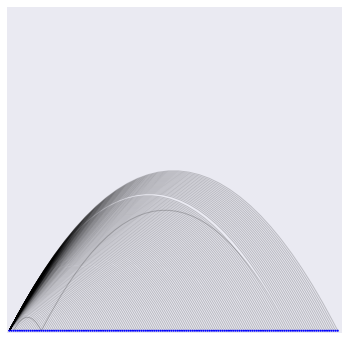

In [6]:
import networkx as nx
import nxviz as nv

G = nx.from_pandas_dataframe(data, 'sender', 'recipient1', edge_attr=['date', 'subject'])
plot = nv.ArcPlot(G)
plot.draw()
plt.show() 

We can see our 500 nodes (employees) at the bottom and the dominance of the one node on the right side.  Please bear in mind, of course, that I am taking the first 500 rows of a 517,000 row dataset here, so we are only looking at emails from one of the 150 Enron executives contained in the full dataset.

Next we'll bend the ends of this plot and join them together to form a circle, otherwise known as a 

CircosPlot
----------

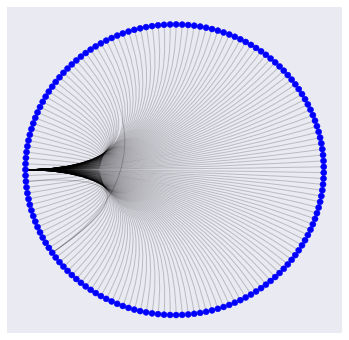

In [7]:
plot = nv.CircosPlot(G)
plot.draw()
plt.show()

Same deal here, although in my opinion a lot clearer and easier to comprehend.

Still, this leaves a lot to be desired. It just doesn't *look* like what most folks expect from a network graph. So next we will use nxviz to 

Draw the Network
----------------

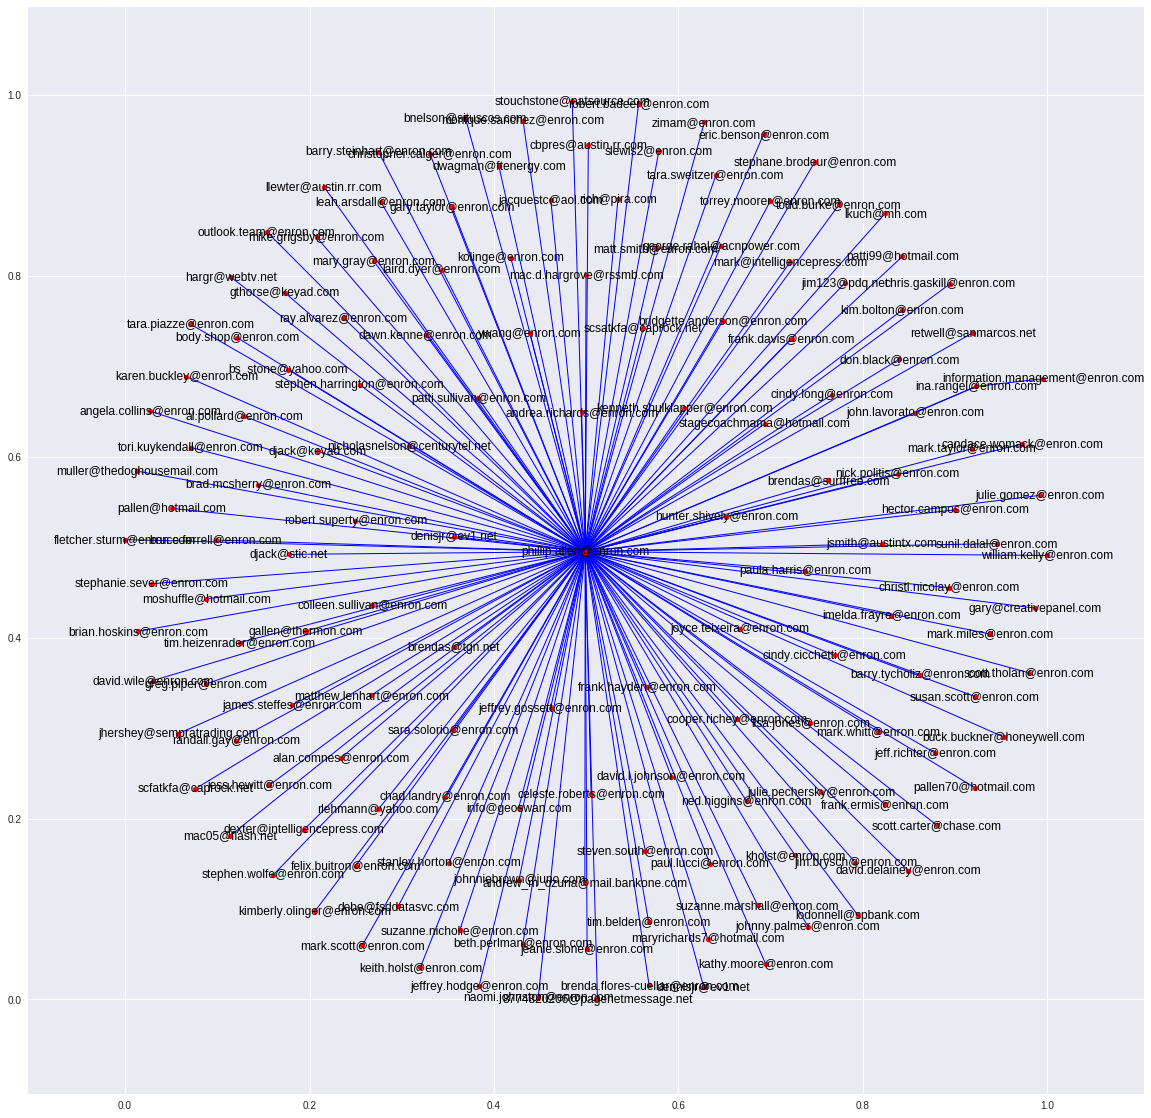

In [8]:
plt.figure(figsize=(20,20))
pos = nx.spring_layout(G, k=.1)
nx.draw_networkx(G, pos, node_size=25, node_color='red', with_labels=True, edge_color='blue')
plt.show()

I plotted this a few times with different "tension" on the spring layout to show some different options for visualizing this network. I've been finding that it pays to use a small 'k' value and plot these with a large figsize (200 x 200 or larger). This produces a big enough graphic to allow you to really zoom in and examine minor details without getting overwhelmed by the number of labels. Of course, if you choose to turn the labels off with with_labels=False you can avoid that issue, but this is no fun (and not particularly interesting) without the names attached.

Just my opinion.

Next we can look at degree centrality, which basically measures the extent to which a given node is connected to all the other nodes. 

Degree Centrality
-----------------

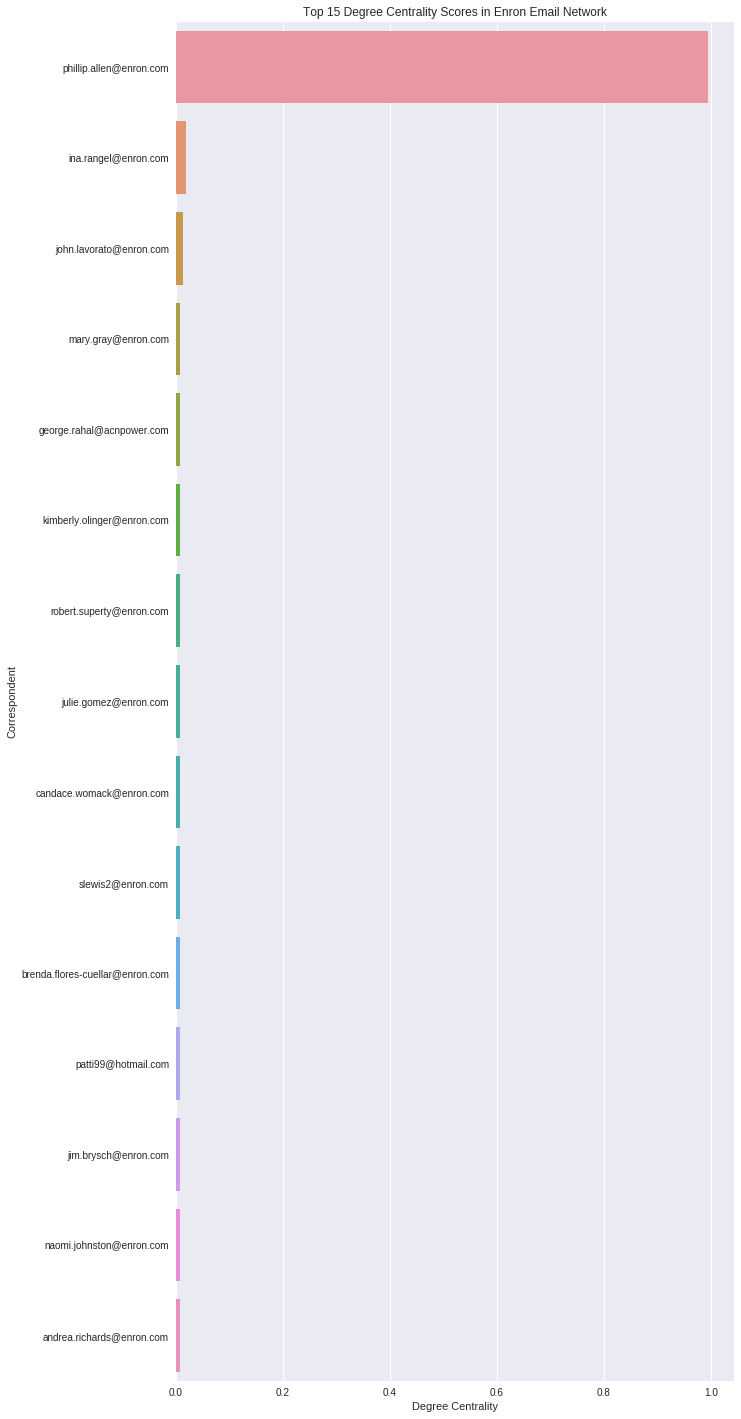

In [9]:
plt.figure(figsize=(20,20))
pos = nx.spring_layout(G, k=.1)
nx.draw_networkx(G, pos, node_size=25, node_color='red', with_labels=True, edge_color='blue')
plt.show()

As you can see, Mr. Allen is connected to everyone. Not surprising, considering we're only really looking at his emails. Next we can look at betweenness centrality, which measures the degree to which each node is the 'single point of contact', so to speak, between other nodes or cliques.

Betweenness Centrality
----------------------

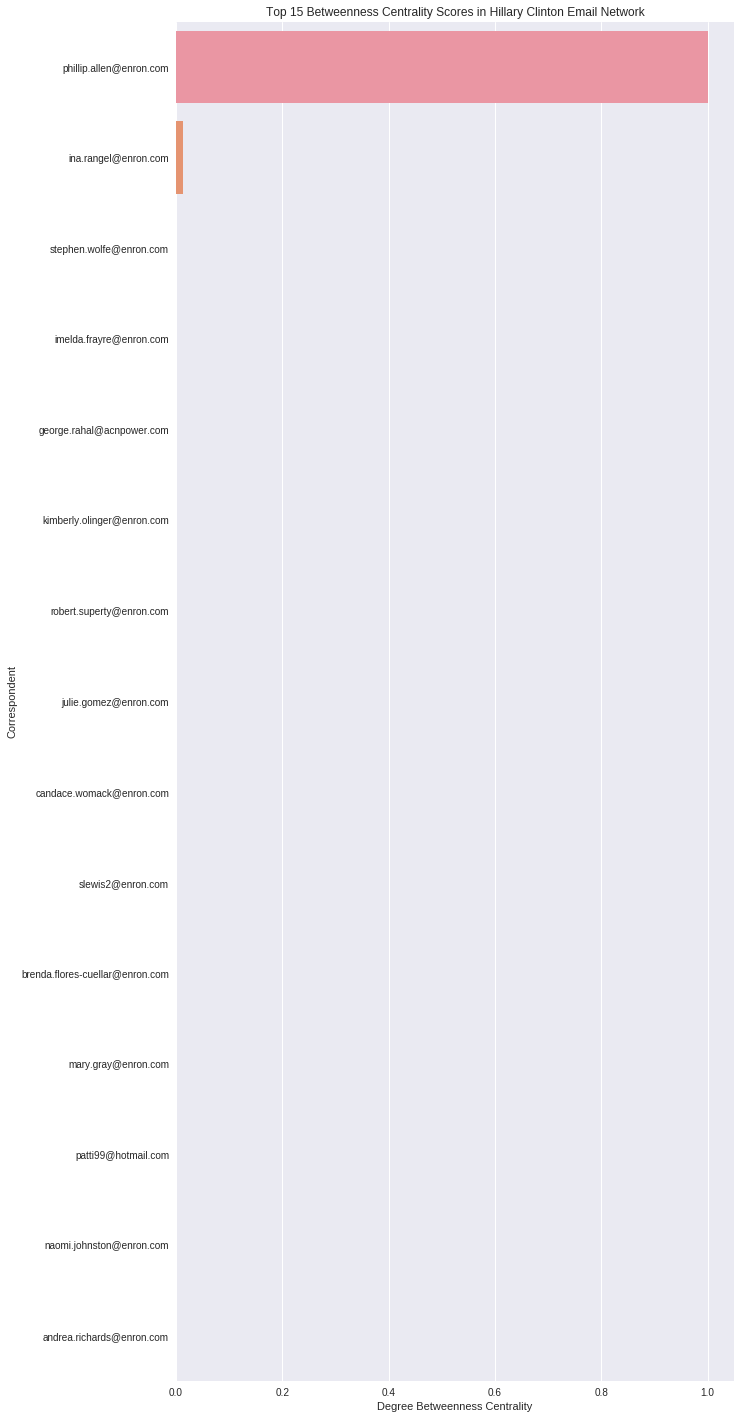

In [10]:
between = nx.betweenness_centrality(G)
name = []
betweenness = []

for key, value in between.items():
    name.append(key)
    betweenness.append(value)

bet = pd.DataFrame()
bet['name'] = name
bet['betweenness'] = betweenness
bet = bet.sort_values(by='betweenness', ascending=False)


plt.figure(figsize=(10, 25))
_ = sns.barplot(x='betweenness', y='name', data=bet[:15], orient='h')
_ = plt.xlabel('Degree Betweenness Centrality')
_ = plt.ylabel('Correspondent')
_ = plt.title('Top 15 Betweenness Centrality Scores in Hillary Clinton Email Network')
plt.show()

Unfortunately that is as far as I can go on this analysis. When I try to scale it up and actually analyze the whole dataset I kill (murder, actually, in cold blood) my kernel. With more computing power, however, I could knock this whole deal out with the same code. So that's something...

Let me know what you think. UPVOTE if you like what you see.